In [2]:
import pyrootutils
import omegaconf
from omegaconf import OmegaConf
import os
import hydra
from hydra import compose, initialize
from pathlib import Path
import torch

/home/cyanos/anaconda3/envs/augtransfer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
root = pyrootutils.setup_root('.', pythonpath=True)
os.chdir(root)

In [10]:
run_dir = root / 'outputs/cifar10_resnet32/runs/rgb_shift/2022-11-16_23-28-47/1'
hydra_cfg_path = run_dir / '.hydra'

In [11]:
with initialize(version_base=None, config_path= '..' / hydra_cfg_path.relative_to(root)):
    cfg = compose(config_name="config", return_hydra_config=True, overrides=["paths.output_dir=notebooks/tmp"])

In [12]:
model = hydra.utils.instantiate(cfg.dmt.model)
model = model.load_from_checkpoint(run_dir / 'lightning_logs/version_0/checkpoints/epoch=199-step=78200.ckpt', net=model.net)

In [13]:
trainer = hydra.utils.instantiate(cfg.dmt.trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
datamodule = hydra.utils.instantiate(cfg.dmt.datamodule, augmentation='blur', test_augmentation='perspective', test_on_train=.4)

In [15]:
metrics = trainer.test(model=model, datamodule=datamodule)

Files already downloaded and verified
Files already downloaded and verified


Missing logger folder: notebooks/tmp/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 18.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.6952000260353088     │
│         test/loss         │    1.2573180198669434     │
└───────────────────────────┴───────────────────────────┘

In [16]:
datamodule = hydra.utils.instantiate(cfg.dmt.datamodule, augmentation='blur')
datamodule.setup('test')
train_loader = datamodule.train_dataloader()

model.cuda()
model.eval()
all_features = []
all_labels = []
train_iter = iter(train_loader)
with torch.no_grad():
    for i in range(100):
        batch = next(train_iter)
        images, labels = batch
        all_labels.append(labels)
        images, labels = images.cuda(), labels.cuda()
        all_features.append(model.net.feature(images).detach().cpu())
all_features = torch.concat(all_features)
all_labels = torch.concat(all_labels)


In [17]:
all_features.shape

torch.Size([12800, 64])

## Feature analysis using t-SNE

In [18]:
import numpy as np
from sklearn import decomposition
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [19]:
X_training = all_features.detach().cpu().numpy()
y_training = all_labels.cpu().numpy()

In [20]:
pca = decomposition.PCA(n_components=30)
X_training_reduced = pca.fit_transform(X_training)

Since t-SNE is quite complex, it is worth to compress the data. Let say that 99% is enough.

In [21]:
np.sum( pca.explained_variance_ratio_ )

0.99867904

In [22]:
tsne = TSNE(n_components=2, init='random', learning_rate='auto')
X_training_reduced_tsne = tsne.fit_transform(X_training_reduced)

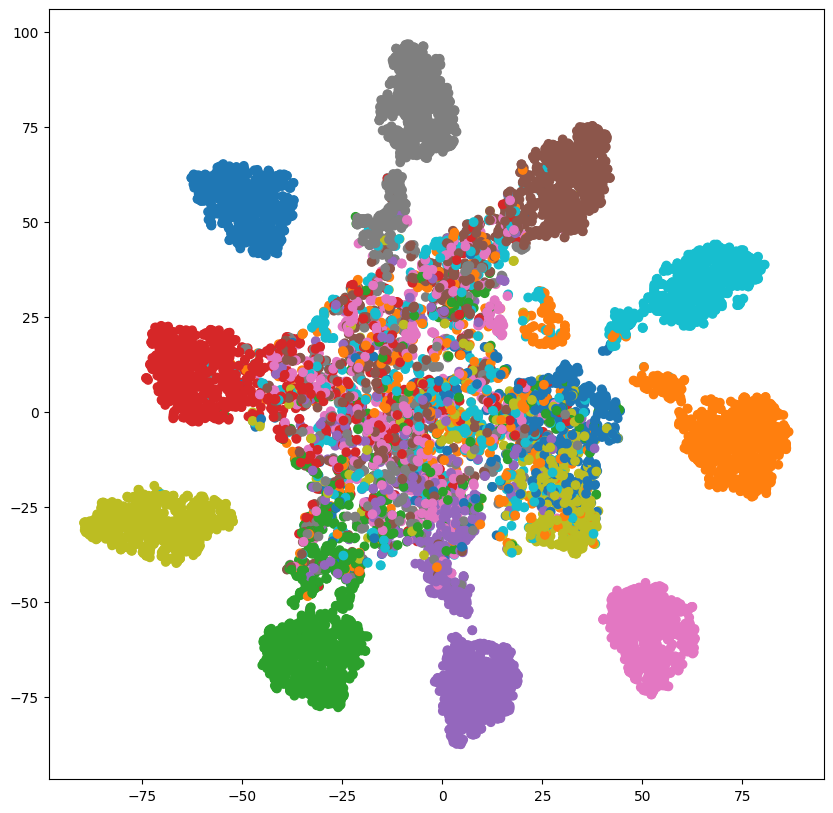

In [23]:
plt.figure( figsize=(10,10) )
plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
plt.show()

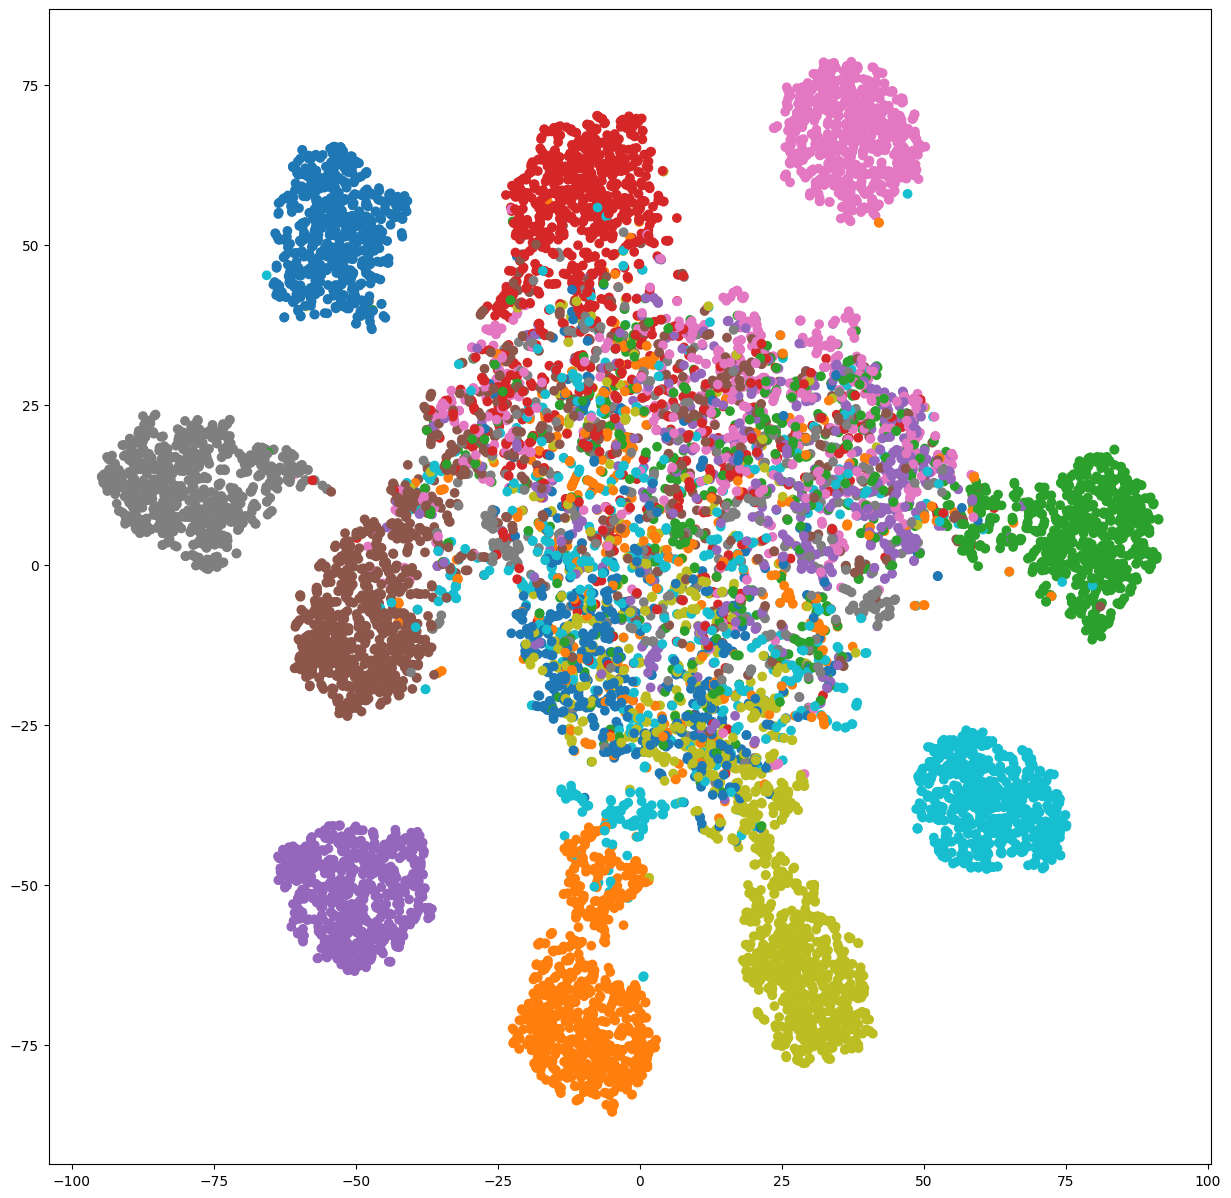

In [68]:
plt.figure( figsize=(10,10) )
plt.scatter( X_training_reduced_tsne[:, 0], X_training_reduced_tsne[:, 1], c=y_training, cmap='tab10' )
plt.show()